# EDA + Simulation Data Preprocessing

Steve Donahue,www.github.com/sdonahue0132

This notebook

1) Collects data on Electronically Traded Funds

2) Develops a functions to generate and evalute portfolios composed of those funds

3) Performs EDA on the distribution of portfolio performances


In [1]:
# Import essential libraries #

import pandas as pd
import numpy as np
from numpy import percentile
import math
import datetime
from datetime import date
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from functools import reduce
import warnings
import io
import requests

warnings.filterwarnings(action='once')

In [4]:
# CSV_Formatter prepares a dataframe of values and a dataframe of percentages for each date of the fund's history. 
# It cleans the csv by isolating one measurement per day, at the Close of business, and then creating
# a shifted column for comparison and creating a column of the daily percent change in value. 
# Both daily value and percent change are retained in two separate dataframes. 

def CSV_Formatter (folder_name, filename):
    df_init = pd.read_csv('raw_data/' + str(folder_name) +'/' + str(filename) +'.csv')
    df = df_init.set_index('Date')[['Adj Close']]
    df.columns = [str(filename)]
    df['Next Day Values'] = df[filename].shift(-1)
    df['Percentages'] = df['Next Day Values']/df[str(filename)]
    df_final = df[['Percentages']]
    df_final.columns = [str(filename)]
    return(df[[filename]], df_final)

# The last function is a weekly master function which collects the percent changes week to week for a domain dataframe
# Domain dataframe should consist only of a date time index and a value series

def clean_label (labels):
    cleaned = str(labels).strip("Index'").replace("_y'", '').replace('Index([', '').replace(']', '').replace(
        ", dtype='object')", '').replace('[', '').replace("'", '').replace("_x'", '').replace('"', '')
    return cleaned

def weekly_master(df, cutoff_date):
    
# A little setup is necessary to ensure fidelity across weekly data.  In the original yahoo finance data downloads,
# Weekends and holidays are not counted in the Datetime Index.  The following code creates a working df that
# Can be broken into calendar weeks at regular 7 day intervals, to better reflect paycheck contributions and 
# subsequent analyses can be done on a week to week basis.

# Note that for days where data is unavailable, I've filled in the value 1, since the method of assessing portfolios
# Is multiplication across daily percentage changes.  In this way, days when no percent changes are documented do not
# affect the value of the investment.

    # NOTE THAT THIS FUNCTION WILL ONLY ACCOMODATE DATAFRAMES WITH UP TO 8 COLUMNS AS WRITTEN! #

    cutoff_date = pd.to_datetime(cutoff_date)
    cutoff = cutoff_date - datetime.timedelta(days=cutoff_date.weekday())
    
    if cutoff_date.weekday() == 6:
        td = timedelta(1)
        cutoff_date = cutoff_date - td
    
    datelist = pd.to_datetime(df.index.values)
    df['Datetime'] = datelist
    df_timed = df.set_index('Datetime')
    labels = df_timed.columns

    df_segmented = pd.DataFrame(columns = labels)

    daterange = int(str(df_timed.index.max() - df_timed.index.min()).replace(" days 00:00:00", ''))
    all_dates = pd.date_range(df_timed.index.min(), periods=daterange).tolist()
    
    index_df = pd.DataFrame(all_dates)
    index_df.columns = ['Datetime']
    
    working_df = index_df.merge(df_timed, how = 'outer', left_on = 'Datetime', right_on ='Datetime')
    working_df = working_df.fillna(1).set_index('Datetime').sort_values('Datetime', ascending = False)
    working_df = working_df.loc[working_df.index <= cutoff_date]
    
    days = len(working_df.index)
    number_of_weeks = int(np.floor(days/7))

    df_progress = pd.DataFrame(index=[0,1,2,3,4])
    weekly_eval = pd.DataFrame()

    for i in range(0, number_of_weeks):
        portfolio_segment = working_df.iloc[i*7:(i+1)*7-1]
        
        products =[]
        prod_1 = portfolio_segment.iloc[:, 0].product()
        products.append(prod_1)

        if len(labels) > 1:
            prod_2 = portfolio_segment.iloc[:, 1].product()
            products.append(prod_2)
        if len(labels) > 2:        
            prod_3 = portfolio_segment.iloc[:, 2].product()
            products.append(prod_3)
        if len(labels) > 3:
            prod_4 = portfolio_segment.iloc[:, 3].product()
            products.append(prod_4)
        if len(labels) > 4:
            prod_5 = portfolio_segment.iloc[:, 4].product()
            products.append(prod_5)
        if len(labels) > 5:
            prod_6 = portfolio_segment.iloc[:, 5].product()
            products.append(prod_6)
        if len(labels) > 6:
            prod_7 = portfolio_segment.iloc[:, 6].product()
            products.append(prod_7)
        if len(labels) > 7:
            prod_8 = portfolio_segment.iloc[:, 7].product()
            products.append(prod_8)
   
    # Can we just make this into a loop?
    # For j in range(0, len(labels)):
    #    temp_prod = portfolio_segment.iloc[:, j].product()
    #    products.append(temp_prod)


        weekly_eval[str(portfolio_segment.index[cutoff_date.weekday()]).replace("00:00:00", '')] = products
    
    weekly_eval = weekly_eval.T
    weekly_eval.columns = labels
    weekly_eval.index = pd.to_datetime(weekly_eval.index)
    weekly_eval.index.name = 'Date'
    weekly_eval.sort_index()

    return(weekly_eval)



In [32]:
# This Cell reads all necessary source files for STOCK INDICES #

(PREIX, PREIX_final) = CSV_Formatter('stock_indices', 'PREIX')
(FUSEX, FUSEX_final) = CSV_Formatter('stock_indices', 'FUSEX')
(SWPPX, SWPPX_final) = CSV_Formatter('stock_indices', 'SWPPX')
(VFINX, VFINX_final) = CSV_Formatter('stock_indices', 'VFINX')
(VIGRX, VIGRX_final) = CSV_Formatter('stock_indices', 'VIGRX')

# Creates dataframes of their daily values and daily percent changes , aka increments.
dfstock_values = [PREIX[['PREIX']], FUSEX[['FUSEX']], SWPPX[['SWPPX']], VFINX[['VFINX']], VIGRX[['VIGRX']]]
dfstock_finals = [PREIX_final, FUSEX_final, SWPPX_final, VFINX_final, VIGRX_final]
stock_daily_values_df = reduce(lambda left, right: pd.merge(left, right, on = 'Date'), dfstock_values)
stock_increments_df = reduce(lambda left, right: pd.merge(left, right, on = 'Date'), dfstock_finals)

stock_weekly = weekly_master(stock_increments_df, '2018-06-01')
stock_weekly.to_csv('csv_files/stock_increments_training.csv')


In [33]:
# This Cell reads all necessary source files for Intermediate Term Bonds #

(BIV, BIV_final) = CSV_Formatter('intermediate_bonds', 'BIV')
(HYG, HYG_final) = CSV_Formatter('intermediate_bonds', 'HYG')
(IEF, IEF_final) = CSV_Formatter('intermediate_bonds', 'IEF')
(IEI, IEI_final) = CSV_Formatter('intermediate_bonds', 'IEI')
(IGIB, IGIB_final) = CSV_Formatter('intermediate_bonds', 'IGIB')
(IPE, IPE_final) = CSV_Formatter('intermediate_bonds', 'IPE')
(ITE, ITE_final) = CSV_Formatter('intermediate_bonds', 'ITE')
(TIP, TIP_final) = CSV_Formatter('intermediate_bonds', 'TIP')

# Creates dataframes of their daily values and daily percent changes , aka increments.
df_itb_values = [BIV[['BIV']], HYG[['HYG']], IEF[['IEF']], IEI[['IEI']], IGIB[['IGIB']], IPE[['IPE']], ITE[['ITE']], TIP[['TIP']]]
df_itb_finals = [BIV_final, HYG_final, IEF_final, IEI_final, IGIB_final, IPE_final, ITE_final, TIP_final]
itb_daily_values_df = reduce(lambda left, right: pd.merge(left, right, on = 'Date'), df_itb_values)
itb_increments_df = reduce(lambda left, right: pd.merge(left, right, on = 'Date'), df_itb_finals)

itb_weekly = weekly_master(itb_increments_df, '2018-06-01')
itb_weekly.to_csv('csv_files/itb_increments_training.csv')



In [34]:
# This Cell reads all necessary source files for Long Term Bonds #

(PRULX, PRULX_final) = CSV_Formatter('long_term_bonds', 'PRULX')
(VUSTX, VUSTX_final) = CSV_Formatter('long_term_bonds', 'VUSTX')
(WHOSX, WHOSX_final) = CSV_Formatter('long_term_bonds', 'WHOSX')

# Creates dataframes of their daily values and daily percent changes , aka increments.
df_ltb_values = [PRULX[['PRULX']], VUSTX[['VUSTX']], WHOSX[['WHOSX']]]
df_ltb_finals = [PRULX_final, VUSTX_final, WHOSX_final]
ltb_daily_values_df = reduce(lambda left, right: pd.merge(left, right, on = 'Date'), df_ltb_values)
ltb_increments_df = reduce(lambda left, right: pd.merge(left, right, on = 'Date'), df_ltb_finals)

ltb_weekly = weekly_master(ltb_increments_df, '2018-06-01')
ltb_weekly.to_csv('csv_files/ltb_increments_training.csv')


In [35]:
# This Cell reads all necessary source files for Gold 

(INIVX, INIVX_final) = CSV_Formatter('gold', 'INIVX')
(OPGSX, OPGSX_final) = CSV_Formatter('gold', 'OPGSX')
(SGGDX, SGGDX_final) = CSV_Formatter('gold', 'SGGDX')
(USERX, USERX_final) = CSV_Formatter('gold', 'USERX')
(VGPMX, VGPMX_final) = CSV_Formatter('gold', 'VGPMX')

# Creates dataframes of their daily values and daily percent changes , aka increments.
dfgold_values = [INIVX[['INIVX']], OPGSX[['OPGSX']], SGGDX[['SGGDX']], USERX[['USERX']], VGPMX[['VGPMX']]]
dfgold_finals = [INIVX_final, OPGSX_final, SGGDX_final, USERX_final, VGPMX_final]
gold_daily_values_df = reduce(lambda left, right: pd.merge(left, right, on = 'Date'), dfgold_values)
gold_increments_df = reduce(lambda left, right: pd.merge(left, right, on = 'Date'), dfgold_finals)

gold_weekly = weekly_master(gold_increments_df, '2018-06-01')
gold_weekly.to_csv('csv_files/gold_increments_training.csv')


In [36]:
# This Cell reads all necessary source files from their respective download folders for Broad Basket Commodities #

(DBC, DBC_final) = CSV_Formatter('broad_commodities', 'DBC')
(DJP, DJP_final) = CSV_Formatter('broad_commodities', 'DJP')
(GSG, GSG_final) = CSV_Formatter('broad_commodities', 'GSG')
(GSP, GSP_final) = CSV_Formatter('broad_commodities', 'GSP')

# Creates dataframes of their daily values and daily percent changes , aka increments.
df_commod_values = [DBC[['DBC']], DJP[['DJP']], GSG[['GSG']], GSP[['GSP']]]
df_commod_finals = [DBC_final, DJP_final, GSG_final, GSP_final]
commod_daily_values_df = reduce(lambda left, right: pd.merge(left, right, on = 'Date'), df_commod_values)
commod_increments_df = reduce(lambda left, right: pd.merge(left, right, on = 'Date'), df_commod_finals)

commod_weekly = weekly_master(commod_increments_df, '2018-06-01')

commod_weekly.to_csv('csv_files/commod_weekly_training.csv')


In [13]:
# This cell creates a function to randomly select the funds in the initial portfolio #

def random_all_weather(stock, inter_bond, long_bond, gold, commod):
    
    # First, select a fund from each investment category
    stock_choice = stock.sample(axis=1).columns
    inter_choice = inter_bond.sample(axis=1).columns
    long_bond_choice = long_bond.sample(axis=1).columns
    gold_choice = gold.sample(axis=1).columns
    commod_choice = commod.sample(axis=1).columns
    
    # Extract the columns of percent changes from the df
    rand_stock_inc = stock_weekly[stock_choice]
    rand_inter_bond_inc = itb_weekly[inter_choice]
    rand_long_bond_inc = ltb_weekly[long_bond_choice]
    rand_gold_inc = gold_weekly[gold_choice]
    rand_commod_inc = commod_weekly[commod_choice]

    random_inc = rand_stock_inc.merge(
        rand_inter_bond_inc, on = 'Date').merge(
        rand_long_bond_inc, on = 'Date').merge(
        rand_gold_inc, on = 'Date').merge(
        rand_commod_inc, on = 'Date')
    
    # Return a portfolio of randomly sampled funds, one in each category, starting at the first date all 5 had value.
    # Please note that the .dropna() here will restrict the amount of historical data leveraged in each portfolio.
    portfolio = random_inc.dropna()
    
    return portfolio



In [14]:
# This is just a test of the random portfolio generating function.

test_random_portfolio = random_all_weather(stock_daily_values_df, 
                   itb_daily_values_df, 
                   ltb_daily_values_df, 
                   gold_daily_values_df, 
                   commod_daily_values_df)


test_random_portfolio.head()



,VFINX,IEI,WHOSX,INIVX,GSG
Date,,,,,
2018-05-28,1.021682,0.991996,0.977004,1.006780,0.987457
2018-05-21,0.984427,1.013279,1.052322,0.987723,0.966391
2018-05-14,1.001742,0.998573,0.983913,0.982456,1.013400
2018-05-07,1.022262,0.997990,0.998714,1.003300,1.017614
2018-04-30,1.009562,1.000595,0.995522,1.021348,1.010333


In [15]:
# Now that we have a randomized portfolio, let's develop some tools to help us understand it.

# Time weighted return captures an accurate total return, accounting for time of accrual.

def time_weighted_return (df):
    sorted_df = df.sort_index(ascending=True).dropna()
    sorted_df['after_cash_flows'] = sorted_df.ending_value + sorted_df.cash_flows
    sorted_df['prev_after_cash_flows'] = sorted_df.after_cash_flows.shift(1)
    sorted_df['HPR'] = (sorted_df.ending_value / sorted_df.prev_after_cash_flows) - 1
    sorted_df['HPR_plus_one'] = sorted_df.HPR + 1
    sorted_df = sorted_df.dropna()

    rate = sorted_df.HPR_plus_one.product()-1
    
    return (rate)
 
# This function is used to compute the Compounded Annual Growth Rate and return the identities and length of investment

def p_summary(performance, fund_identities, term_years):
    twr = time_weighted_return(performance)
    CAGR = (float((1+twr))**(float(1/term_years)) -1)
    return(CAGR, fund_identities, term_years)

#  This function provides a line plot of the portfolio across its length in years.

def p_grapher(test_df):
    test_df['Portfolio Values'] = test_df.sum(axis = 1)
    to_plot = test_df.sort_index(ascending = True)
    return(to_plot.plot(kind = 'line', y = 'Portfolio Values', color='#0504aa').format_xdata(years))

    

In [20]:
# This cell adds a periodic contribution and rebalancing along the user specified proportions #

def periodic_rebalance_tester(invesment_stock, 
                              invesment_itb, 
                              invesment_ltb, 
                              invesment_gold, 
                              invesment_commod, 
                              contribution, 
                              interval):

    test = random_all_weather(stock_daily_values_df, 
                              itb_daily_values_df, 
                              ltb_daily_values_df, 
                              gold_daily_values_df, 
                              commod_daily_values_df).dropna()

    test = test.sort_index(ascending = True)
    test_col = test.iloc[:, 0:5]
    num_weeks = test_col.shape[0]
    number_of_periods = int(np.floor(num_weeks/interval))
    
    
    # This block sets markers in the test dataframe for when to add contributions and when to rebalance.
    a = np.empty((num_weeks,))
    a[::2] = 0
    a[1::2] = 1
    a = a*contribution
    total_contributions = np.asarray(a).sum()
    b = np.zeros((num_weeks,))
    b[:b.size:interval] = 1
    
    test_col['contributions'] = a
    test_col['rebalance_y/n'] = b

    # This block determines the proportions that are targets for rebalancing
    invesment = invesment_stock + invesment_itb + invesment_ltb + invesment_gold + invesment_commod
    inc_stock = invesment_stock / invesment
    inc_itb = invesment_itb / invesment
    inc_ltb = invesment_ltb / invesment
    inc_gold = invesment_gold / invesment
    inc_commod = invesment_commod / invesment
    
    values = test_col.values

    # Progress lists are used to accumulate the values of the incremented investments
    progress_stock = []
    progress_itb = []
    progress_ltb = []
    progress_gold = []
    progress_commod = []
    random_labels = test.iloc[:, 0:5]
    test_labels = str(random_labels.columns)
    fund_identities = str(test_labels).strip('Index').replace('_x', '').replace('([', '').replace("], dtype='object')", '')
    

    # This loop applies the increments to the investment amounts, and appends the results to the progress lists.  
    # The Counter is used to reinvest dividends at the appropriate interval.
    
    counter = 0 
        
    for i,j,k, l, m, n, rebal in values:
        

        invesment_stock = invesment_stock*i + n*inc_stock
        invesment_itb = (invesment_itb*j + n*inc_itb) 
        invesment_ltb = invesment_ltb*k + n*inc_ltb
        invesment_gold = invesment_gold*l + n*inc_gold
        invesment_commod = invesment_commod*m + n*inc_commod
    
        if rebal == 1:
            subtotal = invesment_stock + invesment_itb + invesment_ltb + invesment_gold + invesment_commod
            invesment_stock = subtotal*inc_stock
            invesment_itb = subtotal*inc_itb
            invesment_ltb = subtotal*inc_ltb
            invesment_gold = subtotal*inc_gold
            invesment_commod = subtotal*inc_commod
    
        progress_stock.append(invesment_stock)
        progress_itb.append(invesment_itb)
        progress_ltb.append(invesment_ltb)
        progress_gold.append(invesment_gold)
        progress_commod.append(invesment_commod)
        
        counter = counter + 1
    
    # Lists are converted to arrays, and placed into a performace dataframe, which is evaluated for annualized return %
    result_stock = np.array(progress_stock)
    result_itb = np.array(progress_itb)
    result_ltb = np.array(progress_ltb)
    result_gold = np.array(progress_gold)
    result_commod = np.array(progress_commod)

    test['Stock_Eval'] = result_stock
    test['ITB_Eval']= result_itb
    test['LTB_Eval'] = result_ltb
    test['Gold_Eval'] = result_gold
    test['Commod_Eval']= result_commod

    performance = test.iloc[:, 5:10]
    performance['ending_value'] = performance.sum(axis=1)
    performance['cash_flows'] = a
    performance['rebalanced'] = b
    performance = performance.sort_index(ascending = False)
    term_years = float(len(performance.index)/52.17857)
 
    return (performance, fund_identities, term_years)


C:\Users\taijisteve84\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


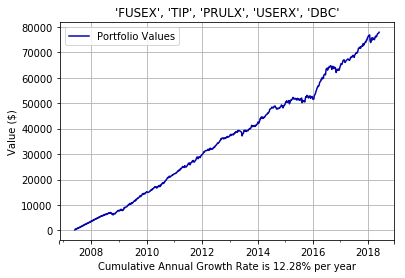

In [21]:
# Here is a visual of an All Weather portfolio with no recurring contributions.  Note it is very much at the mercy
# of the market and experiences a lot of volatility.

test_df, test_identities, test_years = (periodic_rebalance_tester(30, 40, 15, 7.5, 7.5, 100, 26))
CAGR, identities, years = p_summary(test_df, test_identities, test_years)

statement = "Cumulative Annual Growth Rate is " + str(round(CAGR * 100, 2)) + '% per year'

p_grapher(test_df)
plt.title(identities)
plt.grid(axis = 'both')
plt.xlabel(statement)
plt.ylabel('Value ($)')
plt.show()

C:\Users\taijisteve84\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


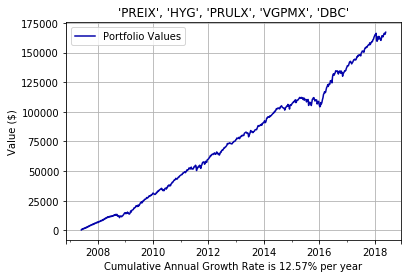

In [22]:
# Here is a similar All Weather portfolio, but now wih a recurring $200 contribution every two weeks.

test_df, test_identities, test_years = (periodic_rebalance_tester(60, 80, 30, 15, 15, 200, 26))
CAGR, identities, years = p_summary(test_df, test_identities, test_years)

statement = "Cumulative Annual Growth Rate is " + str(round(CAGR * 100, 2)) + '% per year'

p_grapher(test_df)
plt.title(identities)
plt.grid(axis = 'both')
plt.xlabel(statement)
plt.ylabel('Value ($)')
plt.show()

C:\Users\taijisteve84\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


95% of trials fall between 11.65 and 13.25 Annualized Return over 11.0 years.


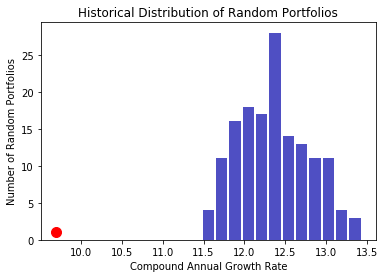

In [23]:
# Now, let's develop some distributions based on the All_Weather Portfolio and let's rebalance every k days
# Here, we see the advice recommended in the book for an All Weather Portfolio.  
# Note that with the following inputs: (300, 400, 150, 75, 75, 1000, 25)
# Note the percentage at the end determines the number of portfolios with a CAGR above 9 from the sample


all_rois = []
all_labels = []

for i in range(150):
    (test_df, test_label, years) = periodic_rebalance_tester(60, 80, 30, 15, 15, 200, 26)
    CAGR, identities, years = p_summary(test_df, test_identities, test_years)
    
    test_roi = round(CAGR*100, 2)
    all_rois.append(test_roi)
    all_labels.append(test_label)
    
roi_array = np.array(all_rois)

d = {'ROI':all_rois, 'Funds':all_labels}

sample_space = pd.DataFrame(data = d)
success_space = sample_space.sort_values(by = ['ROI'], ascending=False).head(10)
message = clean_label(success_space.values)

plt.hist(all_rois, bins = 12, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.xlabel('Compound Annual Growth Rate')
plt.ylabel('Number of Random Portfolios')
plt.title('Historical Distribution of Random Portfolios')
plt.plot([9.7],[1], 'ro', markersize = 10)

statement = '95% of trials fall between ' + str(round(np.percentile(roi_array, 2.5), (2))) + ' and ' + str(round(np.percentile(roi_array,97.5), 2)) + ' Annualized Return over ' + str(round(years, 2)) + ' years.'
    
print(statement)

#percent_above_9 = round(((roi_array > 9).sum())/len(roi_array),2)
#print(percent_above_9)

In [24]:
print('Top performing portfolios: ')
print(message)

Top performing portfolios: 
13.43 VIGRX, IEF, WHOSX, USERX, DJP
 13.41 VIGRX, HYG, WHOSX, SGGDX, DJP
 13.29 VIGRX, BIV, VUSTX, OPGSX, DBC
 13.26 SWPPX, HYG, WHOSX, USERX, DBC
 13.24 VFINX, HYG, WHOSX, USERX, DBC
 13.24 VFINX, HYG, WHOSX, USERX, DBC
 13.23 VIGRX, HYG, WHOSX, VGPMX, GSP
 13.1 VIGRX, HYG, PRULX, USERX, GSG
 13.1 VIGRX, IEF, PRULX, USERX, GSP
 13.09 VIGRX, BIV, WHOSX, VGPMX, GSG


In [27]:
# This function flips the order of weekly percent changes for each fund, moving the Great Recession closer to the 
# end of the tested historical data.  This might be important to study, as the loss in stock value will be more
# dearly felt when there is a larger amount of money in that fund.

def reverser(df):
    df_reversed = df.iloc[::-1]
    df_reversed['Reverse_Index']= df.index
    df_reversed = df_reversed.set_index('Reverse_Index')
    df_reversed.index.names = ['Date']
    return df_reversed

r_stock = reverser(stock_weekly)
r_itb = reverser(itb_weekly)
r_ltb = reverser(ltb_weekly)
r_gold = reverser(gold_weekly)
r_commod = reverser(commod_weekly)


def reverse_rebalancer(invesment_stock, 
                              invesment_itb, 
                              invesment_ltb, 
                              invesment_gold, 
                              invesment_commod, 
                              contribution, 
                              interval):

     # First, select a fund from each investment category
    stock_choice = r_stock.sample(axis=1).columns
    inter_choice = r_itb.sample(axis=1).columns
    long_bond_choice = r_ltb.sample(axis=1).columns
    gold_choice = r_gold.sample(axis=1).columns
    commod_choice = r_commod.sample(axis=1).columns
    
    # Extract the columns of percent changes from the df
    rand_stock_inc = r_stock[stock_choice]
    rand_inter_bond_inc = r_itb[inter_choice]
    rand_long_bond_inc = r_ltb[long_bond_choice]
    rand_gold_inc = r_gold[gold_choice]
    rand_commod_inc = r_commod[commod_choice]

    random_inc = rand_stock_inc.merge(
        rand_inter_bond_inc, on = 'Date').merge(
        rand_long_bond_inc, on = 'Date').merge(
        rand_gold_inc, on = 'Date').merge(
        rand_commod_inc, on = 'Date')
    
    test = random_inc.dropna()
    test = test.sort_index(ascending = True)
    test_col = test.iloc[:, 0:5]
    num_weeks = test_col.shape[0]
    number_of_periods = int(np.floor(num_weeks/interval))
    
    
    # This block sets markers in the test dataframe for when to add contributions and when to rebalance.
    a = np.empty((num_weeks,))
    a[::2] = 0
    a[1::2] = 1
    a = a*contribution
    total_contributions = np.asarray(a).sum()
    b = np.zeros((num_weeks,))
    b[:b.size:interval] = 1
    
    test_col['contributions'] = a
    test_col['rebalance_y/n'] = b
    
    # This block determines the proportions that are targets for rebalancing
    invesment = invesment_stock + invesment_itb + invesment_ltb + invesment_gold + invesment_commod
    inc_stock = invesment_stock / invesment
    inc_itb = invesment_itb / invesment
    inc_ltb = invesment_ltb / invesment
    inc_gold = invesment_gold / invesment
    inc_commod = invesment_commod / invesment
    
    
    values = test_col.values

    # Progress lists are used to accumulate the values of the incremented investments
    progress_stock = []
    progress_itb = []
    progress_ltb = []
    progress_gold = []
    progress_commod = []
    random_labels = test.iloc[:, 0:5]
    test_labels = str(random_labels.columns)
    fund_identities = str(test_labels).strip('Index').replace('_x', '').replace('([', '').replace("], dtype='object')", '')
    
    # This loop applies the increments to the investment amounts, and appends the results to the progress lists

    
    for i,j,k, l, m, n, rebal in values:
        
        invesment_stock = invesment_stock*i + n*inc_stock
        invesment_itb = (invesment_itb*j + n*inc_itb)
        invesment_ltb = invesment_ltb*k + n*inc_ltb
        invesment_gold = invesment_gold*l + n*inc_gold
        invesment_commod = invesment_commod*m + n*inc_commod
    
        if rebal == 1:
            subtotal = invesment_stock + invesment_itb + invesment_ltb + invesment_gold + invesment_commod
            invesment_stock = subtotal*inc_stock
            invesment_itb = subtotal*inc_itb
            invesment_ltb = subtotal*inc_ltb
            invesment_gold = subtotal*inc_gold
            invesment_commod = subtotal*inc_commod
    
        progress_stock.append(invesment_stock)
        progress_itb.append(invesment_itb)
        progress_ltb.append(invesment_ltb)
        progress_gold.append(invesment_gold)
        progress_commod.append(invesment_commod)

    
    # Lists are converted to arrays, and placed into a performace dataframe, which is evaluated for annualized return %
    result_stock = np.array(progress_stock)
    result_itb = np.array(progress_itb)
    result_ltb = np.array(progress_ltb)
    result_gold = np.array(progress_gold)
    result_commod = np.array(progress_commod)

    test['Stock_Eval'] = result_stock
    test['ITB_Eval']= result_itb
    test['LTB_Eval'] = result_ltb
    test['Gold_Eval'] = result_gold
    test['Commod_Eval']= result_commod

    performance = test.iloc[:, 5:10]
    performance['ending_value'] = performance.sum(axis=1)
    performance['cash_flows'] = a
    performance['rebalanced'] = b
    performance = performance.sort_index(ascending = False)
    term_years = float(len(performance.index)/52.17857)
 
    return (performance, fund_identities, term_years)


C:\Users\taijisteve84\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


C:\Users\taijisteve84\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


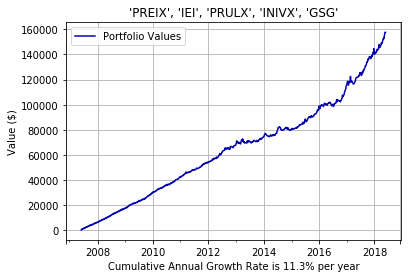

In [28]:
# Similar to what was above.  We examine the volatility associated with the downturn in late 2013

test_df, test_identities, test_years = (reverse_rebalancer(60, 80, 30, 15, 15, 200, 26))
CAGR, identities, years = p_summary(test_df, test_identities, test_years)

statement = "Cumulative Annual Growth Rate is " + str(round(CAGR * 100, 2)) + '% per year'

p_grapher(test_df)
plt.title(identities)
plt.grid(axis = 'both')
plt.xlabel(statement)
plt.ylabel('Value ($)')
plt.show()

C:\Users\taijisteve84\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


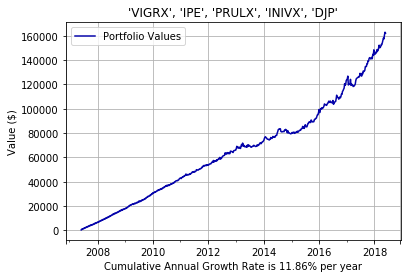

In [29]:
# Here, the monthly contribution helps dampen the volatility, but it is still evident that the portfolio
# begins to struggle in late 2013

test_df, test_identities, test_years = (reverse_rebalancer(60, 80, 30, 15, 15, 200, 25))
CAGR, identities, years = p_summary(test_df, test_identities, test_years)

statement = "Cumulative Annual Growth Rate is " + str(round(CAGR * 100, 2)) + '% per year'

p_grapher(test_df)
plt.title(identities)
plt.grid(axis = 'both')
plt.xlabel(statement)
plt.ylabel('Value ($)')
plt.show()

C:\Users\taijisteve84\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


95% of trials fall between 11.41 and 13.02 Annualized Return over 11.0 years.


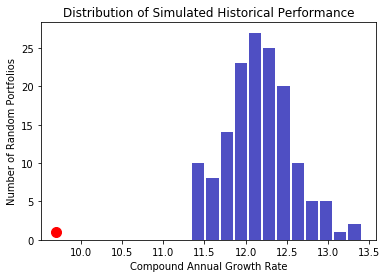

In [30]:
# For good measure, let's see how the portfolio's faired under the reverse historical data.

all_rois = []
all_labels = []

for i in range(150):
    (test_df, test_label, years) = reverse_rebalancer(60, 80, 30, 15, 15, 200, 25)
    CAGR, identities, years = p_summary(test_df, test_identities, test_years)
    
    test_roi = round(CAGR*100, 2)
    all_rois.append(test_roi)
    all_labels.append(test_label)
    
roi_array = np.array(all_rois)

d = {'ROI':all_rois, 'Funds':all_labels}

sample_space = pd.DataFrame(data = d)
success_space = sample_space.sort_values(by = ['ROI'], ascending=False).head(10)
message = clean_label(success_space.values)

plt.hist(all_rois, bins = 12, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.xlabel('Compound Annual Growth Rate')
plt.ylabel('Number of Random Portfolios')
plt.title('Distribution of Simulated Historical Performance')
plt.plot([9.7],[1], 'ro', markersize = 10)

print('95% of trials fall between ' + 
      str(round(np.percentile(roi_array, 2.5), (2))) + 
      ' and ' + str(round(np.percentile(roi_array,97.5), 2)) + 
      ' Annualized Return over ' + str(round(years, 2)) + ' years.')



In [31]:
print('Top performing portfolios: ')
print(message)

Top performing portfolios: 
13.41 FUSEX, HYG, VUSTX, USERX, DBC
 13.24 FUSEX, HYG, PRULX, SGGDX, DBC
 13.18 VFINX, HYG, PRULX, OPGSX, DBC
 13.03 VFINX, IEF, VUSTX, VGPMX, DBC
 13.01 FUSEX, HYG, VUSTX, OPGSX, DJP
 12.97 VIGRX, BIV, VUSTX, SGGDX, DBC
 12.97 VIGRX, IEF, VUSTX, VGPMX, DBC
 12.96 SWPPX, HYG, WHOSX, USERX, DBC
 12.87 FUSEX, HYG, PRULX, VGPMX, DJP
 12.87 VFINX, HYG, PRULX, VGPMX, GSG
